<a href="https://colab.research.google.com/github/drwitt/NLP_IDS_690-03/blob/master/Copy_of_no_out_w_BERT_Ent_as_Fine_Tuning_Classf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adapting BERT classifier for Entailement 
## Retraining on RQE data using the same format as in Fine-Tuning with BERT

Source: https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb

This is an almost identical private version. I removed some comments and added a section of using BERT for entailment by retraining on pairs of sentence. 

## Install and Import

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time. A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [0]:
from datetime import datetime 
"""
print(f'Beginning Training!')
print(f'num_train_steps= ', num_train_steps)
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)
"""
current_time = datetime.now()

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Time took ", datetime.now() - current_time)

Found GPU at: /device:GPU:0
Time took  0:00:03.041794


Next, let's install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained language models (and future models to come - BERT will not be state of the art forever), the library also includes pre-built modifications of BERT suited to your specific task. For example, in this tutorial we will use BertForSequenceClassification, but the library also includes BERT modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

**Note**: as of July 2019, the pytorch library called "pytorch-pretrained-bert pytorch-nlp" has been updated and renamed as "pytorch-transformers." Though the old name still works, there is a short summary [here](https://github.com/huggingface/pytorch-transformers#Migrating-from-pytorch-pretrained-bert-to-pytorch-transformers) about migrating to the new library. (This mostly involves a few name changes.)

In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp


     |████████████████████████████████| 133kB 4.8MB/s 
     |████████████████████████████████| 92kB 26.7MB/s 
     |████████████████████████████████| 655kB 46.3MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609237 sha256=cd326df21baf281b465c186e87be34f401a84f0817a96b075fd2cb82cd955db6
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

print("Time took up to here ", datetime.now() - current_time)

Using TensorFlow backend.


Time took up to here  0:00:21.484230


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print("CUDA: ", torch.cuda.get_device_name(0))



CUDA:  Tesla K80


In [0]:
print("The setup time: ", datetime.now() - current_time)

The setup time:  0:00:21.518680


## Load Dataset


**Mount drive** -- my preferred solution 

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'


In [0]:
### ALTERNATIVE 
# Upload the train file from your local drive
"""
from google.colab import files
uploaded = files.upload()
"""

'\nfrom google.colab import files\nuploaded = files.upload()\n'

In [0]:
""" ANOTHER ALTERNATIVE 
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
"""
drive.mount('/content/drive',force_remount=True) #occasionally needed

Mounted at /content/drive


In [0]:
%%bash

ls /content/drive/My\ Drive/ 

Applied NLP Homework-Paper Comparison.gslides
Boli
Clinical+Tech Venture
Colab Notebooks
Copy of BME MML: Python Quiz Review.gdoc
craigslist-carstrucks-data
Data Dialogues Week 1 Questions.gdoc
DJ Vigs
DS Interview Prep.gdoc
IBM Hotel Discount Codes.xlsx
Lofts At Lakeview.pdf
MML Project Doc.gdoc
Resume-Vignesh Kumaresan.docx
Resume-Vignesh Kumaresan.pdf
Stats.zip
(Working) Copy of FAUJ Lighting Cue Template.gsheet


In [0]:
dfe = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Applied NLP/Copy of OneL-RQE_Train_8588_AMIA2016.tsv", delimiter='\t', \
                  header=None, names=['pair_num', 'label', 'label_notes', 'pairs'])

print(dfe.shape)

dfe.sample(10)

### TODO: randomize dfe

(8588, 4)


,pair_num,label,label_notes,pairs
8197,pid8198typeoriginalQ-shortQ,1,NaN,"chq In regards to perinatal asphyxiation, when..."
8362,pid8363typeoriginalQ-shortQ,1,NaN,chq Where is an article on asthma management? ...
5003,pid5004typeoriginalQ-shortQ,1,NaN,chq What is the purpose for getting an alpha-1...
2837,pid2838typeoriginalQ-shortQ,1,NaN,chq Can dapsone cause a drug fever? echq faq C...
2792,pid2793typeoriginalQ-shortQ,1,NaN,chq What is a Roux-en-Y hepatoenterostomy? ech...
7534,pid7535typeoriginalQ-shortQ,1,NaN,"chq 13-year-old, former shaken baby with resul..."
3338,pid3339typeoriginalQ-shortRandQ,0,NaN,chq How should we be treating diabetes now tha...
1923,pid1924typeoriginalQ-shortQ,1,NaN,chq Is she not sleeping well due to sleep apne...
4092,pid4093typeoriginalQ-shortQ,1,NaN,chq What are the causes of hydramnios? echq fa...
1895,pid1896typeoriginalQ-shortRandQ,0,NaN,"chq If just a sprained finger, I've always won..."


## Preparing the data 

In [0]:
# Create sentence and label lists (we mark the new version by e)
esentences = dfe.pairs.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
esentences = ["[CLS] " + p + " [SEP]" for p in dfe.pairs]
elabels = dfe.label.values


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  
tokenized_etexts = [tokenizer.tokenize(sent) for sent in esentences]
print ("Tokenize a sentence:")
print (tokenized_etexts[3])

print(len(esentences), len(elabels))
print("Time took up to here ", datetime.now() - current_time)

100%|██████████| 231508/231508 [00:00<00:00, 1211906.87B/s]


Tokenize a sentence:
['[CLS]', 'ch', '##q', 'let', "'", 's', 'give', 'these', 'im', '##mun', '##izations', '.', 'that', "'", 's', 'right', 'isn', "'", 't', 'it', '?', 'ec', '##h', '##q', 'fa', '##q', 'let', "'", 's', 'give', 'these', 'im', '##mun', '##izations', '.', 'that', "'", 's', 'right', 'isn', "'", 't', 'it', '?', 'e', '##fa', '##q', '[SEP]']
8588 8588
Time took up to here  0:42:44.823207


In [0]:
test_pairs=esentences[:1500]
test_labels= elabels[:1500]
test_tokenized_etexts = tokenized_etexts[:1500]

esentences= esentences[1500:]
elabels=elabels[1500:]
tokenized_etexts = tokenized_etexts[1500:]


print(len(esentences), len(elabels),len(tokenized_etexts))

7088 7088 7088


In [0]:
# Set the maximum sequence length. The longest sequence in our training set is ??? ,  
# In the original paper, the authors used a length of 512.
MAX_LEN = 128 # this will cut 60 sentences assuming this is length in characters
          #512 is too much for Tesla 4 on colab


# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
einput_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_etexts]

# Pad our input tokens
einput_ids = pad_sequences(einput_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


# Create attention masks
attention_emasks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in einput_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_emasks.append(seq_mask)




# Making sure we have the right shapes
print(1,einput_ids.shape)
print(2,elabels.shape)

print(einput_ids.shape)
print(elabels.shape)



# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(einput_ids, elabels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_emasks, einput_ids,
                                             random_state=2018, test_size=0.1)


print("Time took up to here ", datetime.now() - current_time)

1 (7088, 128)
2 (7088,)
(7088, 128)
(7088,)
Time took up to here  0:42:45.668738


### Comments on the Inputs 
(from the origininal)

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

## Train Model

see the original

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

print("Time took up to here ", datetime.now() - current_time)

Time took up to here  0:42:45.766950


In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

print("Time took up to here ", datetime.now() - current_time)

100%|██████████| 407873900/407873900 [00:11<00:00, 35599890.11B/s]


Time took up to here  0:43:12.370965


Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


print("Time took up to here ", datetime.now() - current_time)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.07898255502805114


Epoch:  50%|█████     | 1/2 [05:19<05:19, 319.85s/it]

Validation Accuracy: 0.9790760869565218
Train loss: 0.017877964630024508


Epoch: 100%|██████████| 2/2 [10:39<00:00, 319.71s/it]

Validation Accuracy: 0.9790760869565218
Time took up to here  0:53:51.720869


Total time from the start and 1 epoch training: 16min
one epoch 3-4 min. (w. GPU)

## Training Evaluation

Let's take a look at our training loss over all batches:

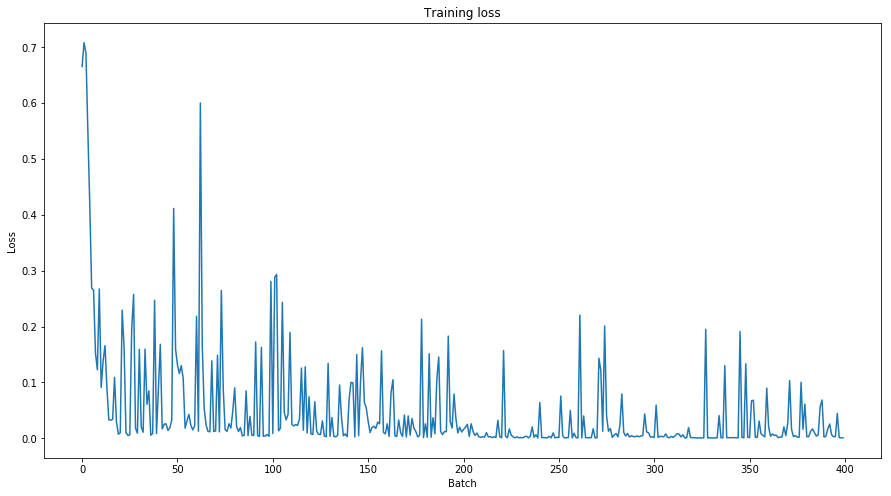

Time took up to here  0:53:52.146559


In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

print("Time took up to here ", datetime.now() - current_time)

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

We previously defined: 

test_pairs=esentences[:1500]

test_labels= elabels[:1500]

test_tokenized_etexts = tokenized_etexts[:1500]

In [0]:


# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = test_pairs
labels =  test_labels

tokenized_texts = test_tokenized_etexts


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print("Time took up to here ", datetime.now() - current_time)

Time took up to here  0:53:52.386165


In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print("Time took up to here ", datetime.now() - current_time)

Time took up to here  0:54:15.987183


In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)


print("Time took up to here ", datetime.now() - current_time)

print(matthews_set)

Time took up to here  0:54:16.048328
[1.0, 1.0, 0.938872452190116, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9393364366277243, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.938872452190116, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9393364366277243, 1.0, 0.938872452190116, 0.8823529411764706, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8745098039215686, 1.0, 1.0, 0.9379228369755696, 1.0, 1.0, 0.9393364366277243, 1.0, 0.9393364366277243, 1.0]


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


print(matthews_corrcoef(flat_true_labels, flat_predictions))

print("TOTAL time ", datetime.now() - current_time)

0.9838670070841533
TOTAL time  0:54:16.070327


### Looking at the results

In [0]:
count=0
for i in range(len(flat_true_labels)):
  if np.abs(flat_predictions[i]-flat_true_labels[i])==1:
    #print(i, flat_predictions[i]-flat_true_labels[i])
    print(i, sentences[i])
    count+=1
print('incorrect', count)
accuracy = (len(flat_true_labels)-count)/len(flat_true_labels)
print('accuracy: ', accuracy)

94 [CLS] chq What is the cause of this woman's long term head shaking (tremor)? echq faq What is the cause of this woman's long term head shaking (tremor)? efaq [SEP]
284 [CLS] chq Another phone conversation with hospital pharmacist regarding providing enough dosage of typhoid capsules for Dr. X and his wife for out of country trip. echq faq How many typhoid vaccine pills do I need to take for my trip to middle east? efaq [SEP]
596 [CLS] chq The cardiologist said in his letter that the patient has a distinct fourth heart sound. Why aren't I hearing the fourth heart sound? I couldn't hear it -- I guess I need to review heart sounds. echq faq Cardiologist heard a distinct S4 (fourth heart sound). Why don't I hear an S4. efaq [SEP]
897 [CLS] chq I don't know why she passed out but it's probably a combination of upper respiratory infection, taking two decongestant-antihistamine combinations, donating blood recently, et cetera. echq faq I don't know why she passed out. efaq [SEP]
965 [CLS] 

## Test on actual task test set

In [0]:
# upload test file
dfe_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Applied NLP/rqe_test_pairs.tsv", delimiter='\t', \
                  header=1, names=['pair_num', 'type', 'label', 'chq', 'faq', 'pairs'])

print(dfe_test.shape)
# drop non-relevant variables
dfe_test.drop(columns=['type', 'chq', 'faq'], inplace=True)
dfe_test.sample(10)

(301, 6)


,pair_num,label,pairs
14,15,1,"chq is there any help available,for fibromalgi..."
165,166,1,chq Questions. i am looking for the latest evi...
218,219,0,chq medicine and allied. I LIKE TO KNOW RECENT...
233,234,0,chq My girlfriend suffers from scoliosis. She ...
1,2,0,chq Arrhythmia. can arrhythmia occurs after ab...
209,210,0,"chq Are large, inoperable schwannomas treatabl..."
227,228,0,chq DVT. Can a birth control called Ocella cau...
28,29,1,"chq lupus. Hi, I want to know about Lupus an..."
93,94,1,"chq Are large, inoperable schwannomas treatabl..."
175,176,1,chq Which drug we I take to stop water come ou...


In [0]:
# Create sentence and label lists (we mark the new version by e)
test_sentences = dfe_test.pairs.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
test_sentences = ["[CLS] " + p + " [SEP]" for p in dfe_test.pairs]
test_labels = dfe_test.label.values


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  
test_tokenized_etexts = [tokenizer.tokenize(sent) for sent in test_sentences]
print ("Tokenize a sentence:")
print (test_tokenized_etexts[3])

print(len(test_sentences), len(test_labels))

Tokenize a sentence:
['[CLS]', 'ch', '##q', 'sleep', 'ap', '##nea', '.', 'i', 'was', 'diagnosed', 'with', 'sleep', 'ap', '##nea', '(', 'pro', '##lly', 'had', 'it', 'for', '5', 'years', ')', 'and', 'i', 'have', 'swelling', 'issues', 'caused', 'from', 'that', '(', 'it', 'has', 'been', 'ruled', 'out', 'from', 'everything', 'else', 'so', 'the', 'doctor', 'thinks', ')', '.', 'i', 'just', 'got', 'my', 'cp', '##ap', 'machine', '.', 'i', 'was', 'wondering', 'how', 'long', 'will', 'it', 'take', 'for', 'the', 'swelling', 'to', 'go', 'away', '.', 'thank', 'you', '!', 'ec', '##h', '##q', 'fa', '##q', 'what', 'is', 'sleep', 'ap', '##nea', '?', 'e', '##fa', '##q', '[SEP]']
301 301


In [0]:
sentences = test_pairs
labels =  test_labels

tokenized_texts = test_tokenized_etexts

MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


print(matthews_corrcoef(flat_true_labels, flat_predictions))

print("TOTAL time ", datetime.now() - current_time)

0.44118657106294934
TOTAL time  2:26:00.930645


In [0]:
count=0
for i in range(len(flat_true_labels)):
  if np.abs(flat_predictions[i]-flat_true_labels[i])==1:
    #print(i, flat_predictions[i]-flat_true_labels[i])
    print(i, sentences[i])
    count+=1
print('incorrect', count)
accuracy = (len(flat_true_labels)-count)/len(flat_true_labels)
print('accuracy: ', accuracy)

0 [CLS] chq How should I treat polymenorrhea in a 14-year-old girl? echq faq How should I treat polymenorrhea in a 14-year-old girl? efaq [SEP]
1 [CLS] chq Have there been any studies with low molecular weight heparin in pregnancy because I have an obstetric patient who had a deep vein thrombosis with her last pregnancy and I'm wondering if I can use it? echq faq Can I use low molecular weight heparin in pregnancy (patient with deep vein thrombosis last pregnancy)? efaq [SEP]
2 [CLS] chq Have there been any studies with low molecular weight heparin in pregnancy because I have an obstetric patient who had a deep vein thrombosis with her last pregnancy and I'm wondering if I can use it? echq faq What are the side effects of Florinef? Could it cause headaches? efaq [SEP]
3 [CLS] chq Let's give these immunizations. That's right isn't it? echq faq Let's give these immunizations. That's right isn't it? efaq [SEP]
5 [CLS] chq Since these boys' father has Marfan's Syndrome, do these boys need 